In [38]:
from pynq import Overlay
import numpy as np
import pandas as pd
ol = Overlay("neural.bit")
ol.ip_dict
 

{'mulb_0': {'type': 'ayush:hls:mulb:1.0',
  'mem_id': 's_axi_control',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_CONTROL_ADDR_WIDTH': '6',
   'C_S_AXI_CONTROL_DATA_WIDTH': '32',
   'C_M_AXI_GMEM_ID_WIDTH': '1',
   'C_M_AXI_GMEM_ADDR_WIDTH': '64',
   'C_M_AXI_GMEM_DATA_WIDTH': '32',
   'C_M_AXI_GMEM_AWUSER_WIDTH': '1',
   'C_M_AXI_GMEM_ARUSER_WIDTH': '1',
   'C_M_AXI_GMEM_WUSER_WIDTH': '1',
   'C_M_AXI_GMEM_RUSER_WIDTH': '1',
   'C_M_AXI_GMEM_BUSER_WIDTH': '1',
   'C_M_AXI_GMEM_USER_VALUE': '0x00000000',
   'C_M_AXI_GMEM_PROT_VALUE': '"000"',
   'C_M_AXI_GMEM_CACHE_VALUE': '"0011"',
   'C_M_AXI_GMEM_ENABLE_ID_PORTS': 'true',
   'C_M_AXI_GMEM_ENABLE_USER_PORTS': 'false',
   'Component_Name': 'design_1_mulb_0_0',
   'clk_period': '10',
   'machine': '64',
   'combinational': '0',
   'latency': '502',
   'II': 'x',
   'EDK_IPTYPE': 'PERIPHERAL',
   'C_S_AXI_CONTROL_BASEADDR': '0x40000000',
   'C_S_AXI_CONTROL_HIGHADDR': '0x4000FFFF',
   'ADDR_WIDT

In [39]:

from pynq import ps

print(ps.Clocks.fclk0_mhz)
ps.Clocks.fclk0_mhz = 250
print(ps.Clocks.fclk0_mhz)
print(ps.Clocks.cpu_mhz)



31.25
250.0
650.0


In [40]:
mult_ip = ol.mulb_0
mmio = mult_ip.mmio

In [41]:
mult_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  inputs_1 = Register(inputs=write-only),
  inputs_2 = Register(inputs=write-only),
  final_1 = Register(final=write-only),
  final_2 = Register(final=write-only)
}

In [42]:
# Create the array with dtype int and shape (100, 1)
inp = np.arange(0, 100).reshape(-1, 1)

# Convert to float32 and reshape to (100,)
inp = inp.astype(np.float32) 
weights_and_biases = np.load('model_wb.npy', allow_pickle=True).item()
# Extract weights and biases for each layer
w1 = weights_and_biases['layer1.weight']
b1 = weights_and_biases['layer1.bias']
w2 = weights_and_biases['layer2.weight']
b2 = weights_and_biases['layer2.bias']
print(f"Shape of w1 (layer1 weight): {w1.shape}")
print(f"Shape of b1 (layer1 bias): {b1.shape}")
print(f"Shape of w2 (layer2 weight): {w2.shape}")
print(f"Shape of b2 (layer2 bias): {b2.shape}")
print(f"Shape of input  : {inp.shape}")

Shape of w1 (layer1 weight): (10, 1)
Shape of b1 (layer1 bias): (10,)
Shape of w2 (layer2 weight): (1, 10)
Shape of b2 (layer2 bias): (1,)
Shape of input  : (100, 1)


In [43]:
from pynq import allocate
import numpy as np 
#mult ip
a = allocate(shape=(100,), dtype=np.float32)   #input1
b = allocate(shape=(100,), dtype=np.float32)   #final_1 

In [44]:
print("py_buffer physical address {}".format(hex(a.physical_address)))
print("py_buffer physical address {}".format(hex(b.physical_address)))
# print("py_buffer physical address {}".format(hex(c.physical_address)))

py_buffer physical address 0x1684a000
py_buffer physical address 0x1684b000


In [45]:
mult_ip.register_map.inputs_1 = a.physical_address 
mult_ip.register_map.final_1  = b.physical_address

## Hardware Implementation

In [46]:
def regression_hw(inp):
    # Write to input buffer
    a[:] = inp
    # Send start signal
    mult_ip.register_map.CTRL.AP_START =1
    
    # Wait until algorithm has completed
    while (mult_ip.register_map.CTRL.AP_DONE == 0):
        pass

    return b

## Software Implementation


In [47]:
def relu(x):
    return np.maximum(0, x)

In [48]:
def regression_sw(inp):
    layer1_output = relu(np.dot(inp, w1.T) + b1)
    output = np.dot(layer1_output, w2.T) + b2
    return output

## Main program

In [49]:
reg_hw = regression_hw(inp.flatten())
reg_sw = regression_sw(inp)
reg_sw = reg_sw.ravel()    

In [50]:

df_comparison = pd.DataFrame({
    'Index': np.arange(len(reg_hw)),
    'reg_hw': reg_hw,
    'reg_sw': reg_sw,
    'Difference': reg_hw - reg_sw
})

print(df_comparison)

    Index      reg_hw      reg_sw  Difference
0       0    3.508896    3.508896    0.000000
1       1    4.977297    4.977297    0.000000
2       2    6.135975    6.724675   -0.588700
3       3    8.472054    8.472054    0.000000
4       4    9.185570   10.209666   -1.024096
..    ...         ...         ...         ...
95     95  190.870819  190.900848   -0.030029
96     96  171.063873  192.902374  -21.838501
97     97  192.123230  194.903931   -2.780701
98     98  174.614212  196.905472  -22.291260
99     99  198.876968  198.907013   -0.030045

[100 rows x 4 columns]


Detailed Comparison Table:
   Index    reg_hw     reg_sw  Difference
0      0  3.508896   3.508896    0.000000
1      1  4.977297   4.977297    0.000000
2      2  6.135975   6.724675   -0.588700
3      3  8.472054   8.472054    0.000000
4      4  9.185570  10.209666   -1.024096

Descriptive Statistics:
                 Mean   Std Dev       Min         Max
reg_hw       94.46158  54.82839  3.508896   198.87697
reg_sw      99.968513  57.55595  3.508896  198.907013
Difference  -5.506921  6.938743 -22.29126    0.810989


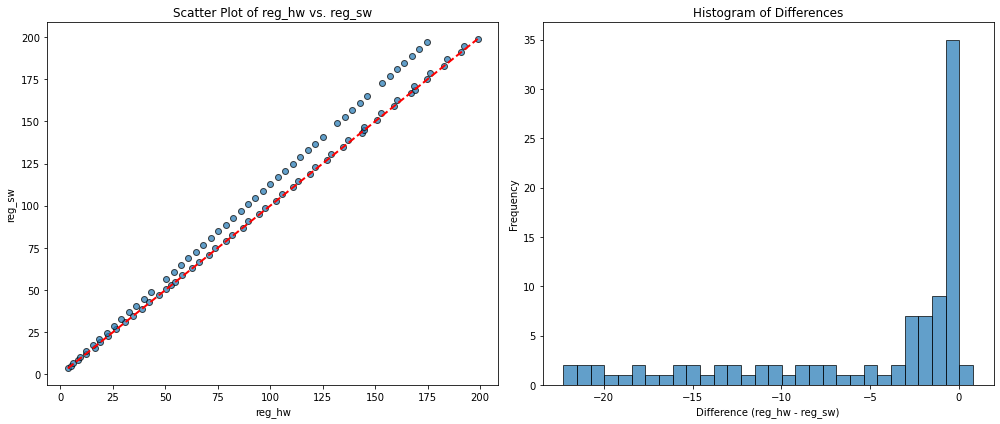

In [51]:
import matplotlib.pyplot as plt
# Compute descriptive statistics
stats_summary = pd.DataFrame({
    'Mean': [reg_hw.mean(), reg_sw.mean(), df_comparison['Difference'].mean()],
    'Std Dev': [reg_hw.std(), reg_sw.std(), df_comparison['Difference'].std()],
    'Min': [reg_hw.min(), reg_sw.min(), df_comparison['Difference'].min()],
    'Max': [reg_hw.max(), reg_sw.max(), df_comparison['Difference'].max()],
}, index=['reg_hw', 'reg_sw', 'Difference'])

# Display the DataFrame
print("Detailed Comparison Table:")
print(df_comparison.head())  # Show only the first few rows for brevity
print("\nDescriptive Statistics:")
print(stats_summary)

# Plotting
plt.figure(figsize=(14, 6))

# Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(reg_hw, reg_sw, alpha=0.7, edgecolors='k')
plt.plot([reg_hw.min(), reg_hw.max()], [reg_hw.min(), reg_hw.max()], 'r--', lw=2)
plt.xlabel('reg_hw')
plt.ylabel('reg_sw')
plt.title('Scatter Plot of reg_hw vs. reg_sw')

# Histogram of Differences
plt.subplot(1, 2, 2)
plt.hist(df_comparison['Difference'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Difference (reg_hw - reg_sw)')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')

plt.tight_layout()
plt.show()

In [52]:
hw_time = %timeit -n 1 -r 10 -o regression_hw(inp.flatten())
sw_time = %timeit -n 1 -r 10 -o regression_sw(inp)

print('Performance gain:', sw_time.average / hw_time.average) 

398 µs ± 95.6 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)
The slowest run took 15.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1.17 ms ± 1.36 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Performance gain: 2.9398167711982883


In [53]:
print("hw fps = {:.1f}".format((hw_time.average/10000)**-1))
print("sw fps = {:.1f}".format((sw_time.average/10000)**-1))

hw fps = 25153587.8
sw fps = 8556175.4


## Free the Buffer

In [37]:
del a , b 